## Aprendizado Profundo

### O Tensor

In [1]:
Tensor = list

from typing import List

# Encontrando a forma do tensor
def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]

    return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

In [2]:
# Como os tensores tem várias dimensões, em geral trabalharemos com eles recursivamente

def is_1d(tensor: Tensor) -> bool:
    """
    Se o tensor [0] é uma lista, é um tensor de ordem superior.
    Se não, o tensor é unidimensional (ou seja, um vetor).
    """
    return not isinstance(tensor[0], list)

assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4]])

In [3]:
# Função auxiliar para somar tensores recursivamente

def tensor_sum(tensor: Tensor) -> float:
    """Soma todos os valores do tensor"""
    if is_1d(tensor):
        return sum(tensor)                  # apenas uma lista de floats, use a soma Python
    else:
        return sum(tensor_sum(tensor_i)     # Chame tensor_sum em cada linha
                   for tensor_i in tensor)  # e some esses resultados

assert tensor_sum([1, 2, 3]) == 6
assert tensor_sum([[1, 2], [3, 4]]) == 10

In [4]:
from typing import Callable

# Função auxiliar elementwise 
def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """Aplica f elementwise"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4]]) == [[2, 4], [6, 8]]

In [5]:
# Função auxiliar que cria um tensor zero com a forma de um determinado tensor
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1, 2, 3]) == [0, 0, 0]
assert zeros_like([[1, 2], [3, 4]]) == [[0, 0], [0, 0]]

In [6]:
# Também aplicaremos uma função aos elementos correspondentes de dois tensores
# que devem ter a mesma forma

def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Aplica f aos elementos correspondentes de t1 e t2"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
                for t1_i, t2_i in zip(t1, t2)]

import operator
assert tensor_combine(operator.add, [1, 2, 3], [4, 5, 6]) == [5, 7, 9]
assert tensor_combine(operator.mul, [1, 2, 3], [4, 5, 6]) == [4, 10, 18]

### Abstração de Camadas

In [7]:
from typing import Iterable, Tuple

# Abstração fundamental: um compoenente que sabe aplicar uma função nas entradas
# e retropropagar nas saídas.

class Layer:
    """
    Nossas redes neurais serão compostas por Layers que sabem
    computar as entradas "pra frente" e propagar gradientes "para trás".
    """
    def forward(self, input):
        """
        Observe que não há tipos. Não indicaremos expressamente os
        tipos de entradas que serão recebidas pelas camadas nem os
        tipos de saídas que elas retornarão.
        """
        raise NotImplemented

    def backward(self, gradient):
        """
        Da mesma forma, não indicaremos expressamente o formato do
        gradiente. Cabe ao usuário (você) avaliar se está fazendo as
        coisas de forma razoável.
        """
        raise NotImplemented

    def params(self):
        """
        Retorna os parâmetros desta camada. Como a implementação padrão
        não retorna nada, se houver uma camada sem parâmetros, você não
        precisará implementar isso.
        """
        return ()
    
    def grads(self) -> Iterable[Tensor]:
        """
        Retorna os gradientes na mesma ordem dos params().
        """
        return ()

In [8]:
import import_ipynb
from neural_networks import sigmoid

class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        """
        Aplique a sigmoid em todos os elementos do tensor de 
        entrada e salve os resultados para usar na retropropagação.
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                              self.sigmoids,
                              gradient)

importing Jupyter notebook from neural_networks.ipynb
importing Jupyter notebook from linear_algebra.ipynb
importing Jupyter notebook from gradient_descent.ipynb


### A Camada Linear

In [9]:
import random

from probability import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 0.0,
                  variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
                for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
                for _ in range(dims[0])]
    
assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
assert shape(random_normal(5, 6, mean=10)) == [5, 6]

importing Jupyter notebook from probability.ipynb


In [10]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f'unknown init: {init}')

In [11]:
from typing import Iterable
from linear_algebra import dot

class Linear(Layer):
    def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
        """
        A layer of output_dim neurons, each with input_dim weights
        (and a bias).
        """
        self.input_dim = input_dim
        self.output_dim = output_dim

        # self.w[o] is the weights for the o-th neuron
        self.w = random_tensor(output_dim, input_dim, init=init)

        # self.b[o] is the bias term for the o-th neuron
        self.b = random_tensor(output_dim, init=init)

    def forward(self, input: Tensor) -> Tensor:
        # Save the input to use in the backward pass.
        self.input = input

        # Return the vector of neuron outputs.
        return [dot(input, self.w[o]) + self.b[o]
                for o in range(self.output_dim)]

    def backward(self, gradient: Tensor) -> Tensor:
        # Each b[o] gets added to output[o], which means
        # the gradient of b is the same as the output gradient.
        self.b_grad = gradient

        # Each w[o][i] multiplies input[i] and gets added to output[o].
        # So its gradient is input[i] * gradient[o].
        self.w_grad = [[self.input[i] * gradient[o]
                        for i in range(self.input_dim)]
                       for o in range(self.output_dim)]

        # Each input[i] multiplies every w[o][i] and gets added to every
        # output[o]. So its gradient is the sum of w[o][i] * gradient[o]
        # across all the outputs.
        return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.b_grad]

# class Linear(Layer):
#     def __init__(self, input_dim: int, output_dim: int, init: str = 'xavier') -> None:
#         """
#         Uma camada de neurônios output_dim com pesos input_dim
#         (e um viés).
#         """
#         self.input_dim = input_dim
#         self.output_dim = output_dim

#         # self.w[o] representa os pesos do neurônio o
#         self.w = random_tensor(output_dim, input_dim, init=init)

#         # self.b[o] representa o termo de viés do neurônio o
#         self.b = random_tensor(output_dim, init=init)

#     def forward(self, input: Tensor) -> Tensor:
#         # Salve a entrada para usar na transmissão para trás
#         self.input = input

#         # Retorne o vetor das saídas dos neurônios
#         return [dot(input, self.w[o]) + self.b[o]
#                 for o in range(self.output_dim)]
    
#     def backward(self, gradient: Tensor) -> Tensor:
#         # Cada b[o] é adicionado ao output[o], indicando que
#         # o gradiente de b é igual ao gradiente de saída
#         self.b_grad = gradient

#         # Cada w[o][i] multiplica o input[i] e é adicionado ao output[o].
#         # Portanto, seu gradiente é input[i] * gradient[o].
#         self.w_grad = [[self.input[i] * gradient[o]
#                         for i in range(self.input_dim)]
#                         for o in range(self.output_dim)]
        
#         # Cada input[i] multiplica o w[o][i] e é adicionado ao
#         # output[o]. Portanto, seu gradiente é a soma w[o][i] * gradient[o]
#         # em todas as saídas.
#         return [
#             sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
#             for i in range(self.input_dim)
#         ]
    
#     def params(self) -> Iterable[Tensor]:
#         return [self.w, self.b]
    
#     def grads(self) -> Iterable[Tensor]:
#         return [self.w_grad, self.b_grad]     
        

### Redes Neurais Como Sequencias de Camadas

In [12]:
from typing import List

class Sequential(Layer):
    """
    Uma camada é uma sequência de outras camadas.
    Cabe a você avaliar se há coerência entre a saída de uma camada 
    e a entrada da próxima camada.
    """
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers

    def forward(self, input):
        """Só avance a entrada pelas camadas em sequência."""
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, gradient):
        """Só retropropague o gradient pelas camadas na sequência inversa."""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient

    def params(self) -> Iterable[Tensor]:
        """Só retorne os params de cada camada."""
        return (param for layer in self.layers for param in layer.params())

    def grads(self) -> Iterable[Tensor]:
        """Só retorne os grads de cada camada."""
        return (grad for layer in self.layers for grad in layer.grads())

In [13]:
# Represenando a rede neural que usamos para XOR

xor_net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=2, output_dim=1),
    Sigmoid()
])

### Perda e Otimização

In [14]:
# Abstração Loss para computar as perdas e gradientes
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """Qual é a qualidade das previsões? (Os números maiores são piores)."""
        raise NotImplemented

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """Como a perda muda a medida que mudam as previsões?"""
        raise NotImplemented

In [15]:
# A perda é a soma dos erros quadráticos
class SSE(Loss):
    """A função da perda que computa a soma dos erros quadráticos."""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Compute o tensor das diferenças quadráticas
        squared_errors = tensor_combine(
            lambda predicted, actual: (predicted - actual) ** 2,
            predicted,
            actual
        )

        # E some tudo
        return tensor_sum(squared_errors)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
            lambda predicted, actual: 2 * (predicted - actual),
            predicted,
            actual
        )

In [16]:
# Abstração de otimização
class Optimizer:
    """
    O otimizador atualiza os pesos de uma camada (no local) usando informações
    conhecidas pela camada ou pelo otimizador (ou por ambos).
    """
    def step(self, layer: Layer) -> None:
        raise NotImplemented

In [17]:
# Implementando gradiente descedente 
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate

    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # Atualize o param utilizando um passo de gradiente
            param[:] = tensor_combine(
                lambda param, grad: param - grad * self.lr,
                param,
                grad
            )
            

In [19]:
# Um pouco do básico do python
tensor = [[1, 2], [3, 4]]

for row in tensor:
    row = [0, 0]
assert tensor == [[1, 2], [3, 4]], 'a atribuição não atualiza a lista'

for row in tensor:
    row[:] = [0, 0]
assert tensor == [[0, 0], [0, 0]], 'mas a atribuição de fatia sim'

In [18]:
class Momentum(Optimizer):
    def __init__(self, learning_rate: float, momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []     # média móvel

    def step(self, layer: Layer) -> None:
        # Se não houver atualizações anteriores, começe com zeros
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]
        
        for update, param, grad in zip(self.updates, layer.params(), layer.grads()):
            # Aplique o momentum
            update[:] = tensor_combine(
                lambda u, g: self.mo * u + (1 - self.mo) * g,
                update,
                grad
            )

            # Em seguida, dê um passo de gradiente
            param[:] = tensor_combine(
                lambda p, u: p - self.lr * u,
                param,
                update
            )

In [130]:
import tqdm

def train1():
    # Dados de treinamento
    xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
    ys = [[0.], [1.], [1.], [0.]]

    random.seed(0)

    net = Sequential([
        Linear(input_dim=2, output_dim=2),
        Sigmoid(),
        Linear(input_dim=2, output_dim=1)
    ])

    optimizer = GradientDescent(learning_rate=0.1)
    loss = SSE()

    with tqdm.trange(3000) as t:
        for epoch in t:
            epoch_loss = 0.0

            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)

                optimizer.step(net)

            t.set_description(f"xor loss {epoch_loss:.3f}")
    
    for param in net.params():
        print(param)

### Outras Funções de Ativação

In [20]:
import math

def tanh(x: float) -> float:
    # Se x for muito grande ou muito pequeno, tanh será (essencialmente) 1 ou -1.
    # Verificamos isso porque, por exemplo, math.exp(1000) gera erro.
    if x < -100: return -1
    elif x > 100: return 1

    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

In [21]:

class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # Salva a saída de tanh para usar na transmissão para trás
        self.tanh = tensor_apply(tanh, input)
        return self.tanh
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda tanh, grad: (1 - tanh ** 2) * grad,
            self.tanh,
            gradient
        )

In [22]:
# Em redes maiores uma alternativa é a Relu, que indica 0 para entradas negativas e a identidade para entradas positivas
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_apply(lambda x: max(x, 0), input)
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
            lambda x, grad: grad if x > 0 else 0,
            self.input,
            gradient
        )

### Voltando ao Exemplo do FizzBuzz

In [132]:
from neural_networks import binary_encode, fizz_buzz_encode, argmax

NUM_HIDDEN = 25

def fizz_buzz_accuracy(low: int, hi: int, net: Layer) -> float:
    num_correct = 0
    for n in range(low, hi):
        x = binary_encode(n)
        predicted = argmax(net.forward(x))
        actual = argmax(fizz_buzz_encode(n))
        if predicted == actual:
            num_correct += 1

    return num_correct / (hi - low)

def train2():
    xs = [binary_encode(n) for n in range(101, 1024)]
    ys = [fizz_buzz_encode(n) for n in range(101, 1024)]


    random.seed(0)

    net = Sequential([
        Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
        Tanh(),
        Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
        Sigmoid()
    ])

    optimizer = Momentum(learning_rate=0.1, momentum=0.9)
    loss = SSE()

    with tqdm.trange(1000) as t:
        for epoch in t:
            epoch_loss = 0.0

            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)

                optimizer.step(net)
        
            accuracy = fizz_buzz_accuracy(101, 1024, net)
            t.set_description(f"fb loss: {epoch_loss:.2f} acc: {accuracy:.2f}")

    print("test results", fizz_buzz_accuracy(1, 101, net))


### Softmaxes e Entropia Cruzada

In [23]:
# Função softmax que calcula a probailidade de um determinado item dentro do vetor pertencer a alguma classe
def softmax(tensor: Tensor) -> Tensor:
    """Softmax na última dimensão"""
    if is_1d(tensor):
        # Subtraia o maior valor para fins de estabilidade numérica
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]
        
        sum_of_exps = sum(exps)                             # este é o peso total.
        return [exp_i / sum_of_exps                         # A probabilidade é a fração
                for exp_i in exps]                          # do peso tota.
    
    else:
        return [softmax(tensor_i) for tensor_i in tensor]

In [24]:

class SoftmaxCrossEntropy(Loss):
    """
    Esse é o log de verossimilhança negativa dos valores observados neste modelo de rede neural.
    Portanto, se escolhermos os pesos para minimizá-los, o modelo maximizará a verossimilhança dos dados observados.
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # Aplique o softmax para obter as probabilidades
        probabilities = softmax(predicted)

        # Este será o log p_i para a classe i real e 0 para as outras classes.
        # Adicionamos uma pequena quantidade a p para evitar o log (0)
        likelihoods = tensor_combine(
            lambda p, act: math.log(p + 1e-30) * act,
            probabilities,
            actual
        )

        # Em seguida, somamos os negativos
        return -tensor_sum(likelihoods)
    
    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)

        # Uma bela equação agradável, não acha ?
        return tensor_combine(
            lambda p, actual: p - actual,
            probabilities,
            actual
        )

In [ ]:
def train3():
    random.seed(0)

    net = Sequential([
        Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
        Tanh(),
        Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
        # sem a camada sigmoid final
    ])

    optimizer = Momentum(learning_rate=0.1, momentum=0.9)
    loss = SoftmaxCrossEntropy()

    with tqdm.trange(100) as t:
        for epoch in t:
            epoch_loss = 0.0

            for x, y in zip(xs, ys):
                predicted = net.forward(x)
                epoch_loss += loss.loss(predicted, y)
                gradient = loss.gradient(predicted, y)
                net.backward(gradient)

                optimizer.step(net)
            
            accuracy = fizz_buzz_accuracy(101, 1024, net)
            t.set_description(f"fb loss: {epoch_loss:.3f} acc: {accuracy:.2f}")

    # Verifique novamente os resultados no conjunto de teste
    print("test results", fizz_buzz_accuracy(1, 101, net))

### Dropout

In [25]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True

    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # Crie uma máscara de 0s e 1s com formato da entrada
            # usando a probabilidade específica
            self.mask = tensor_apply(
                lambda _: 0 if random.random() < self.p else 1, 
                input
            )
            # Multiplique pela máscara para desligar as entradas
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # Durante a avaliação, reduza as saídas uniformemente
            return tensor_apply(lambda x: x * (1 - self.p), input)
        
    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # Propague apenas os gradientes em que a máscara == 1.
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")
    

In [26]:
!python -m pip install scikit-learn

  Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached threadpoolctl-3.4.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl (10.6 MB)
   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ------------------- -------------------- 143.4/301.2 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------  297.0/301.2 kB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 3.1 MB/s eta 0:00:00
Using cached scipy-1.13.0-cp311-cp311-win_amd64.whl (46.2 MB)
Using cached threadpoolctl-3.4.0-py3-none-any.whl (17 kB)


### Exemplo MNIST

In [114]:
from sklearn.datasets import fetch_openml
from machine_learning import train_test_split

mnist = fetch_openml('mnist_784', version=1)

X, y = mnist['data'], mnist['target'].astype(float)

# X = X.to_numpy()
# y = y.to_numpy()

X.shape, y.shape

((70000, 784), (70000,))

In [121]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [122]:
train_images = x_train.to_numpy()
test_images = x_test.to_numpy()

train_labels = y_train.to_numpy()
test_labels = y_test.to_numpy()

In [124]:
test_labels.shape

(10000,)

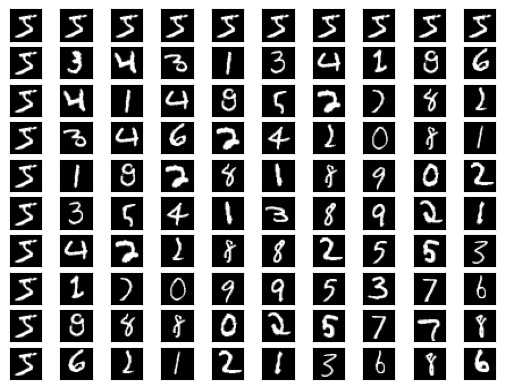

In [103]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10, 10)

for i in range(10):
    for j in range(10):
        # Plote cada imagem em preto e branco e oculte os eixos
        ax[i][j].imshow(train_images[10 * i * j].reshape(28, 28), cmap='gray')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)

In [125]:
# # Compute o valor médio do pixel
# avg = tensor_sum(train_images) / 60000 / 28 / 28

# # Centralize novamente, redimensione e mescle
# train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
#                 for image in train_images]
# test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
#                 for image in test_images]

assert train_images.shape == (60000, 784), 'images should be flatten'
assert test_images.shape == (10000, 784),  'images should be flatten'

# Após a centralização, o pixel médio deve estar muito próximo de 0
# assert -0.0001 < tensor_sum(train_images) < 0.0001

In [126]:
# Codificação OneHotEncoding

def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

assert one_hot_encode(3) == [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
assert one_hot_encode(2, num_labels=5) == [0, 0, 1, 0, 0]

In [127]:
# Depois aplicaremos a função aos dados

train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]

assert shape(train_labels) == [60000, 10]
assert shape(test_labels) == [10000, 10]

In [128]:
def loop(model: Layer,
         images: List[Tensor],
         labels: List[Tensor],
         loss: Loss,
         optimizer: Optimizer = None
         ) -> None:
    correct = 0             # Monitore o número de previsões corretas
    total_loss = 0.0        # Monitore a perda total

    with tqdm.trange(len(images)) as t:
        for i in t:
            predicted = model.forward(images[i])                # Preveja.
            if argmax(predicted) == argmax(labels[i]):          # Verifique a
                correct += 1                                    # correção
            total_loss += loss.loss(predicted, labels[i])       # Compute a perda

            # Se estiver treinanando, faça a retropropagação do gradient e atualize os pesos.
            if optimizer is not None:
                gradient = loss.gradient(predicted, labels[i])
                model.backward(gradient)
                optimizer.step(model)

            # E atualize as métricas na barra de progresso.
            avg_loss = total_loss / (i + 1)
            acc = correct / (i + 1)
            t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")

In [133]:
random.seed(0)

# A regressão logística é apenas uma camada linear seguida pelo softmax
model = Linear(784, 10)
loss = SoftmaxCrossEntropy()

# Este otimizador parece funcionar
optimizer = Momentum(learning_rate=0.01, momentum=0.99)

# Treine com os dados de treinamento
loop(model, train_images, train_labels, loss, optimizer)

# Teste com os dados de teste (se não houver nenhum otimizador, só avalie)
loop(model, test_images, test_labels, loss)

mnist loss: 21.343 acc: 0.690:   3%|▎         | 1653/60000 [03:01<1:46:48,  9.10it/s]


KeyboardInterrupt: 

In [134]:
random.seed(0)

# Atribua nomes para ativar e desativar o treinamento
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)

model = Sequential([
    Linear(784, 30),             # Camada oculta 1: tamanho 30
    dropout1,
    Tanh(),
    Linear(30, 10),             # Camada oculta 2: tamanho 10
    dropout2,
    Tanh(),
    Linear(10, 10)              # Camada de saída: tamanho 10
])

optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()

dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)

# Desative o dropout e avalie
dropout1.train = dropout2.train = False
loop(model, test_images, test_labels, loss)

mnist loss: 2.272 acc: 0.159:   3%|▎         | 1983/60000 [10:27<5:06:01,  3.16it/s]


KeyboardInterrupt: 

In [ ]:
# Salvando os pesos de uma rede treinada

import json

def save_weights(model: Layer, filename: str)-> None:
    weights = list(model.params())

    with open(filename, 'w') as f:
        json.dump(weights, f)

def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)

    # Verifique a consistência
    assert all(shape(param) == shape(weights) for param, weight in zip(model.params(), weights))

    # Em seguida, carregue usando a atribuição de fatia
    for param, weight in zip(model.params(), weights):
        param[:] = weight